# prepare dataset

# train dataset


- Reads `train.csv` to get article IDs and `real_text_id`.  
- Loops through each `article_xxxx` folder, reads `file_1.txt` and `file_2.txt`.  
- Appends texts with labels:  
  - `1` → real text  
  - `0` → fake text  
- Builds a `DataFrame` with `text` and `label` columns for training.  
- Prints the first 10 rows and the total number of examples.


In [1]:
import os
import pandas as pd

def create_dataset(base_path):
    df = pd.read_csv(os.path.join(base_path, 'train.csv'))
    df['id'] = df['id'].astype(int)
    df['real_text_id'] = df['real_text_id'].astype(int)

    train_folder = os.path.join(base_path, 'train')

    texts = []
    labels = []

    for _, row in df.iterrows():
        folder_name = f"article_{row['id']:04d}"
        folder_path = os.path.join(train_folder, folder_name)

        file1 = os.path.join(folder_path, 'file_1.txt')  
        file2 = os.path.join(folder_path, 'file_2.txt')  

        if not os.path.isfile(file1) or not os.path.isfile(file2):
            print(f"Fichiers manquants dans {folder_path}, on ignore")
            continue

        with open(file1, 'r', encoding='utf-8') as f:
            text1 = f.read()

        with open(file2, 'r', encoding='utf-8') as f:
            text2 = f.read()

        if row['real_text_id'] == 1:
            texts.append(text1)
            labels.append(1)
            texts.append(text2)
            labels.append(0)
        else:
            texts.append(text2)
            labels.append(1)
            texts.append(text1)
            labels.append(0)

    dataset_df = pd.DataFrame({'text': texts, 'label': labels})
    return dataset_df
base_path = r'/kaggle/input/fake-or-real-the-impostor-hunt/data'
df_dataset = create_dataset(base_path)
print(df_dataset.head(10))
print(f"Total exemples : {len(df_dataset)}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
                                                text  label
0  The VIRSA (Visible Infrared Survey Telescope A...      1
1  The China relay network has released a signifi...      0
2  The project aims to achieve an accuracy level ...      1
3  China\nThe goal of this project involves achie...      0
4  Scientists can learn about how galaxies form a...      1
5  Dinosaur eggshells offer clues about what dino...      0
6  The importance for understanding how stars evo...      1
7  China\nThe study suggests that multiple star s...      0
8  Analyzing how fast stars rotate within a galax...      1
9  Dinosaur Rex was excited about his new toy set...      0
Total exemples : 190


In [2]:
df_dataset.rename(columns={'label': 'cible'}, inplace=True)

# test dataset



- Loops through all `article_xxxx` folders in the `test` directory.  
- Reads `file_1.txt` and `file_2.txt` for each article.  
- Stores each text with an `article_id` (`xxxx_1` or `xxxx_2`).  
- Builds a `DataFrame` with `article_id` and `text` columns, ready for prediction.  
- Prints the first rows and the total number of test examples.


In [3]:
import os
import pandas as pd

def create_test_dataset(base_path):
    test_folder = os.path.join(base_path, 'test')
    
    texts = []
    article_ids = []

    # Parcours de chaque dossier article
    for folder_name in sorted(os.listdir(test_folder)):
        folder_path = os.path.join(test_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue
        
        file1 = os.path.join(folder_path, 'file_1.txt')
        file2 = os.path.join(folder_path, 'file_2.txt')

        # Vérifie que les fichiers existent
        if not os.path.isfile(file1) or not os.path.isfile(file2):
            print(f"Fichiers manquants dans {folder_path}, on ignore")
            continue

        # Lecture des fichiers
        with open(file1, 'r', encoding='utf-8') as f:
            texts.append(f.read())
            article_ids.append(folder_name + '_1')
        with open(file2, 'r', encoding='utf-8') as f:
            texts.append(f.read())
            article_ids.append(folder_name + '_2')

    test_df = pd.DataFrame({'article_id': article_ids, 'text': texts})
    return test_df
test_base_path = r'/kaggle/input/fake-or-real-the-impostor-hunt/data'
df_test = create_test_dataset(test_base_path)

print(df_test.head())
print(f"Total exemples de test : {len(df_test)}")

       article_id                                               text
0  article_0000_1  "Music" Music music music Music music Music mu...
1  article_0000_2  Since its launch on Paranal observatory's Very...
2  article_0001_1  underground exploration on SN's birth has prov...
3  article_0001_2  SN 1987A provides valuable insights as newer o...
4  article_0002_1  This research aimed to understand how star sha...
Total exemples de test : 2136


# preprocessing data

# Text Preprocessing – Explained Steps

Here is what we do for each text in the dataset `df_dataset`:

---

## 1️⃣ Lowercasing
Standardize all words so that "China" and "china" are treated the same.  

| Original Text | After Lowercasing |
|---------------|-----------------|
| The VIRSA observes galaxies. | the virsa observes galaxies |
| China 2025 report! | china 2025 report! |

---

## 2️⃣ Remove punctuation and numbers
Remove all non-alphabetic characters (punctuation, digits, symbols).  

| After Lowercasing | After Removing Punctuation/Numbers |
|-----------------|-----------------------------------|
| the virsa observes galaxies | the virsa observes galaxies |
| china 2025 report! | china report |

---

## 3️⃣ Tokenization
Split the text into words (tokens).  

| Cleaned Text | Tokens |
|--------------|--------|
| the virsa observes galaxies | [the, virsa, observes, galaxies] |
| china report | [china, report] |

---

## 4️⃣ Stopword Removal & Lemmatization
- **Stopwords**: frequent but uninformative words (the, a, has, etc.)  
- **Lemmatization**: reduce words to their root (observes → observe, galaxies → galaxy)  

| Tokens | After Stopwords & Lemmatization |
|--------|-------------------------------|
| [the, virsa, observes, galaxies] | [virsa, observe, galaxy] |
| [china, has, released, report] | [china, release, report] |

---

## 5️⃣ Reconstruct Cleaned Sentence
Join the filtered tokens back into a single sentence for the model.  

| Lemmatized Tokens | clean_text |
|-----------------|------------|
| [virsa, observe, galaxy] | virsa observe galaxy |
| [china, release, report] | china release report |

---

## ✅ Final Example in `df_dataset`

| Original Text | clean_text | tokens | label |
|---------------|------------|--------|-------|
| The VIRSA observes galaxies. | virsa observe galaxy | [virsa, observe, galaxy] | 1 |
| China has released a report. | china release report | [china, release, report] | 0 |
| The project aims to achieve an accuracy level of 95%. | project aim achieve accuracy level | [project, aim, achieve, accuracy, level] | 1 |
| China\nThe goal of this project involves achieving better coverage. | china goal project involve achieve better coverage | [china, goal, project, involve, achieve, better, coverage] | 0 |
| Scientists can learn about how galaxies form and evolve. | scientist learn galaxy form evolve | [scientist, learn, galaxy, form, evolve] | 1 |


# train dataset

In [4]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    clean_text = ' '.join(tokens)
    return clean_text, tokens

df_dataset['clean_text'], df_dataset['tokens'] = zip(*df_dataset['text'].apply(preprocess_text))
print(df_dataset.head())


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


                                                text  cible  \
0  The VIRSA (Visible Infrared Survey Telescope A...      1   
1  The China relay network has released a signifi...      0   
2  The project aims to achieve an accuracy level ...      1   
3  China\nThe goal of this project involves achie...      0   
4  Scientists can learn about how galaxies form a...      1   

                                          clean_text  \
0  virsa visible infrared survey telescope array ...   
1  china relay network released significant amoun...   
2  project aim achieve accuracy level dex analyzi...   
3  china goal project involves achieving accuracy...   
4  scientist learn galaxy form evolve two method ...   

                                              tokens  
0  [virsa, visible, infrared, survey, telescope, ...  
1  [china, relay, network, released, significant,...  
2  [project, aim, achieve, accuracy, level, dex, ...  
3  [china, goal, project, involves, achieving, ac...  
4  [scien

# Loading GloVe Embeddings(300d) for NLP

## Main Idea
The code **loads pre-trained word vectors** from GloVe and stores them in a Python dictionary.  
- Each word is associated with a **numerical vector** representing its meaning.  
- These vectors are then used in NLP models (classification, translation, summarization, etc.).

## What is GloVe?
- **GloVe (Global Vectors for Word Representation)** converts words into **real-number vectors**.  
- Example: `vec("king") - vec("man") + vec("woman") ≈ vec("queen")`.  
- Trained on large text corpora to capture relationships between words.

## Usefulness
- Helps NLP models understand the meaning of words.  
- Avoids the need to train your own embeddings.  
- Saves time and computational resources.


In [5]:
import numpy as np
glove_path = '/kaggle/input/glove-embeddings/glove.6B.300d.txt'
glove_embeddings = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()   
        word = values[0]               
        vector = np.array(values[1:], dtype='float32')  
        glove_embeddings[word] = vector
print(f"Number of words loaded: {len(glove_embeddings)}")

Number of words loaded: 400000


# Creating Document Vectors with GloVe

## Main Idea
This code **converts each document into a single vector** using the preloaded GloVe embeddings.  
- Each word in the document is transformed into a **numerical vector** using GloVe.  
- The vectors of all words are **averaged** to obtain a single vector representing the document.  
- This enables machine learning models to **directly work with a numerical representation of the text**.

## How It Works
1. The `document_vector` function takes:  
   - `tokens`: list of words in the document  
   - `embeddings_dict`: GloVe embeddings  
   - `dim`: dimension of the vectors (here 300)  

2. It retrieves the vector of each word found in GloVe.  
3. If no word is found, it returns a **zero vector**.  
4. Otherwise, it computes the **average of the word vectors** to represent the document.  
5. The resulting matrix `X_glove` contains one row per document.

## Usefulness
- Transforming text into numerical vectors is **essential for NLP tasks**.  
- Document vectors can be used for:  
  - Text classification  
  - Sentiment analysis  
  - Clustering or similarity search


In [6]:
import numpy as np

def document_vector(tokens, embeddings_dict, dim=300):
    vecs = [embeddings_dict[word] for word in tokens if word in embeddings_dict]
    
    if len(vecs) == 0:
        return np.zeros(dim) 
    return np.mean(vecs, axis=0)
X_glove = np.vstack(df_dataset['tokens'].apply(lambda x: document_vector(x, glove_embeddings)))
print("Shape of GloVe document vectors:", X_glove.shape)  

Shape of GloVe document vectors: (190, 300)


# Adding GloVe Vectors to the DataFrame

## Main Idea
This code **adds GloVe vectors as new columns** to each article in the main DataFrame.  
- Each article is already represented by a 300-dimensional GloVe vector.  
- These vectors become **additional columns** in the DataFrame.  
- This allows classification models to use these **numerical representations** directly.

## How It Works
1. Convert the `X_glove` matrix into a DataFrame `glove_df` with one column per dimension (`glove_0`, `glove_1`, ..., `glove_299`).  
2. Reset the indices of `df_dataset` and `glove_df` so they are aligned.  
3. Concatenate the two DataFrames horizontally to add the GloVe columns to the articles.  
4. Check the new shape of the DataFrame and preview it using `head()`.

## Usefulness
- Each article now has **300 new numerical features**.  
- These vectors can be used as **inputs for a classification model** (SVM, Random Forest, etc.).  
- Improves the model’s ability to **understand the content and meaning of the articles**.


In [7]:
import pandas as pd
glove_df = pd.DataFrame(X_glove, columns=[f'glove_{i}' for i in range(X_glove.shape[1])])
df_dataset = df_dataset.reset_index(drop=True)
glove_df = glove_df.reset_index(drop=True)
df_dataset = pd.concat([df_dataset, glove_df], axis=1)
print("New shape of df_dataset:", df_dataset.shape)
print(df_dataset.head())

New shape of df_dataset: (190, 304)
                                                text  cible  \
0  The VIRSA (Visible Infrared Survey Telescope A...      1   
1  The China relay network has released a signifi...      0   
2  The project aims to achieve an accuracy level ...      1   
3  China\nThe goal of this project involves achie...      0   
4  Scientists can learn about how galaxies form a...      1   

                                          clean_text  \
0  virsa visible infrared survey telescope array ...   
1  china relay network released significant amoun...   
2  project aim achieve accuracy level dex analyzi...   
3  china goal project involves achieving accuracy...   
4  scientist learn galaxy form evolve two method ...   

                                              tokens   glove_0   glove_1  \
0  [virsa, visible, infrared, survey, telescope, ... -0.162039  0.117231   
1  [china, relay, network, released, significant,... -0.142063  0.108321   
2  [project, aim, ac

# Named Entity Features for Articles

## Overview
This step extracts **named entity information** from each word in the articles using SpaCy.  
- Each word is checked to see if it belongs to an entity (like Person, Organization, Location, Date).  
- Results are stored in a new column `ner_tokens` in the DataFrame.  

## How It Works
- Load SpaCy’s English model (`en_core_web_sm`).  
- For each article, create a list of entity types for its words.  
- Words without an entity get an empty value (`''`).  

## Why It’s Useful
- Adds **semantic context** to each article.  
- Helps the classifier detect patterns like mentions of companies, locations, or people.  
- Can be combined with **GloVe embeddings** for improved text classification.


In [8]:
import spacy
nlp = spacy.load("en_core_web_sm")
def ner_per_token(text):
    doc = nlp(text)
    return [token.ent_type_ for token in doc] 
df_dataset['ner_tokens'] = df_dataset['text'].apply(ner_per_token)

# Encoding Named Entities into Numeric Features

## Main Idea
This code **converts named entity types (NER) into numerical values** so that machine learning models can use them.  
- Each unique entity type (Person, Organization, Date, etc.) is assigned a **unique number**.  
- The numeric representation is stored in a new column `ner_tokens_numeric`.

## How It Works
1. Flatten all lists of entities from the dataset into a single list.  
2. Extract the **unique entity types**.  
3. Initialize a `LabelEncoder` and fit it to the unique types.  
4. Transform each article’s list of entities into a **list of numbers** using the encoder.  

## Usefulness
- Converts NER information into a **format usable by ML models**.  
- Can be combined with **GloVe vectors** or other features.  
- Helps improve **text classification performance** by including entity information.


In [9]:
from sklearn.preprocessing import LabelEncoder
all_ner = [ent for sublist in df_dataset['ner_tokens'] for ent in sublist]
unique_ner = list(set(all_ner))
le = LabelEncoder()
le.fit(unique_ner)
df_dataset['ner_tokens_numeric'] = df_dataset['ner_tokens'].apply(lambda x: le.transform(x))

In [10]:
print(df_dataset.head())

                                                text  cible  \
0  The VIRSA (Visible Infrared Survey Telescope A...      1   
1  The China relay network has released a signifi...      0   
2  The project aims to achieve an accuracy level ...      1   
3  China\nThe goal of this project involves achie...      0   
4  Scientists can learn about how galaxies form a...      1   

                                          clean_text  \
0  virsa visible infrared survey telescope array ...   
1  china relay network released significant amoun...   
2  project aim achieve accuracy level dex analyzi...   
3  china goal project involves achieving accuracy...   
4  scientist learn galaxy form evolve two method ...   

                                              tokens   glove_0   glove_1  \
0  [virsa, visible, infrared, survey, telescope, ... -0.162039  0.117231   
1  [china, relay, network, released, significant,... -0.142063  0.108321   
2  [project, aim, achieve, accuracy, level, dex, ... -0.

# Text Preprocessing for Test Articles

## Main Idea
This code **preprocesses the text of test articles** to clean and standardize it for NLP tasks.  
- Converts text to **lowercase**, removes **punctuation and non-letter characters**.  
- Tokenizes the text into words and removes **stopwords**.  
- Applies **lemmatization** to reduce words to their base form.  
- Returns both the **cleaned text** and the list of **tokens**.

## How It Works
1. Load NLTK resources: `punkt`, `stopwords`, `wordnet`, `omw-1.4`.  
2. Define stopwords and a lemmatizer.  
3. `preprocess_text(text)` function:  
   - Lowercase the text.  
   - Remove non-letter characters.  
   - Tokenize and remove stopwords.  
   - Lemmatize tokens.  
   - Return cleaned text and tokens.  
4. Apply the function to each test article and store results in `clean_text` and `tokens` columns.

## Usefulness
- Produces **standardized and clean text** for NLP models.  
- Reduces noise and improves performance for **classification, embeddings, or other NLP tasks**.  
- Provides tokenized text for creating **features like GloVe embeddings or NER**.

In [11]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    clean_text = ' '.join(tokens)
    
    return clean_text, tokens
df_test['clean_text'], df_test['tokens'] = zip(*df_test['text'].apply(preprocess_text))
print(df_test.head())


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


       article_id                                               text  \
0  article_0000_1  "Music" Music music music Music music Music mu...   
1  article_0000_2  Since its launch on Paranal observatory's Very...   
2  article_0001_1  underground exploration on SN's birth has prov...   
3  article_0001_2  SN 1987A provides valuable insights as newer o...   
4  article_0002_1  This research aimed to understand how star sha...   

                                          clean_text  \
0  music music music music music music music musi...   
1  since launch paranal observatory large telesco...   
2  underground exploration sn birth provided valu...   
3  sn provides valuable insight newer observatory...   
4  research aimed understand star shape differ pe...   

                                              tokens  
0  [music, music, music, music, music, music, mus...  
1  [since, launch, paranal, observatory, large, t...  
2  [underground, exploration, sn, birth, provided...  
3  [sn, pr

# GloVe Document Vectors for Test Articles

Convert each test article into a single vector by averaging GloVe embeddings of its words.  
These vectors can be used as features for machine learning models for text classification.


In [12]:
import numpy as np

def document_vector(tokens, embeddings_dict, dim=300):
    vecs = [embeddings_dict[word] for word in tokens if word in embeddings_dict]
    
    if len(vecs) == 0:
        return np.zeros(dim)  
    return np.mean(vecs, axis=0)
X_glove_test = np.vstack(df_test['tokens'].apply(lambda x: document_vector(x, glove_embeddings)))
print("Shape of GloVe document vectors (test):", X_glove_test.shape) 

Shape of GloVe document vectors (test): (2136, 300)


# Adding GloVe Vectors to Test DataFrame

Add the GloVe vectors as new columns to each test article for use in machine learning models.  
Each article now has 300 additional numeric features representing its content.


In [13]:
import pandas as pd
glove_df_test = pd.DataFrame(X_glove_test, columns=[f'glove_{i}' for i in range(X_glove_test.shape[1])])
df_test = df_test.reset_index(drop=True)
glove_df_test = glove_df_test.reset_index(drop=True)
df_test = pd.concat([df_test, glove_df_test], axis=1)
print("New shape of df_test:", df_test.shape)
print(df_test.head())

New shape of df_test: (2136, 304)
       article_id                                               text  \
0  article_0000_1  "Music" Music music music Music music Music mu...   
1  article_0000_2  Since its launch on Paranal observatory's Very...   
2  article_0001_1  underground exploration on SN's birth has prov...   
3  article_0001_2  SN 1987A provides valuable insights as newer o...   
4  article_0002_1  This research aimed to understand how star sha...   

                                          clean_text  \
0  music music music music music music music musi...   
1  since launch paranal observatory large telesco...   
2  underground exploration sn birth provided valu...   
3  sn provides valuable insight newer observatory...   
4  research aimed understand star shape differ pe...   

                                              tokens   glove_0   glove_1  \
0  [music, music, music, music, music, music, mus... -0.134582  0.068664   
1  [since, launch, paranal, observatory, lar

# Named Entity Recognition (NER) for Test Articles

Use SpaCy’s English model (`en_core_web_sm`) to extract **named entities** for each word in test articles.  
- Each token in a text gets an entity type using `token.ent_type_` (Person, Organization, Location, etc.).  
- If a token is not part of any entity, its type is empty.  

Representation for a document with tokens t1, t2, ..., tn:  
NER(doc) = [ent(t1), ent(t2), ..., ent(tn)]  
where ent(ti) is the entity type of token ti, or empty if none.


In [14]:
import spacy

nlp = spacy.load("en_core_web_sm")
def ner_per_token(text):
    doc = nlp(text)
    return [token.ent_type_ for token in doc] 
df_test['ner_tokens'] = df_test['text'].apply(ner_per_token)

In [15]:
df_test['ner_tokens_numeric'] = df_test['ner_tokens'].apply(lambda x: le.transform(x))
print(df_test.head())

       article_id                                               text  \
0  article_0000_1  "Music" Music music music Music music Music mu...   
1  article_0000_2  Since its launch on Paranal observatory's Very...   
2  article_0001_1  underground exploration on SN's birth has prov...   
3  article_0001_2  SN 1987A provides valuable insights as newer o...   
4  article_0002_1  This research aimed to understand how star sha...   

                                          clean_text  \
0  music music music music music music music musi...   
1  since launch paranal observatory large telesco...   
2  underground exploration sn birth provided valu...   
3  sn provides valuable insight newer observatory...   
4  research aimed understand star shape differ pe...   

                                              tokens   glove_0   glove_1  \
0  [music, music, music, music, music, music, mus... -0.134582  0.068664   
1  [since, launch, paranal, observatory, large, t... -0.052423  0.085890   
2 

# train dataset tretment


- Adds a `num_tokens` column → number of tokens in each text.  
- Adds a `num_chars` column → number of characters in the cleaned text.  
- Displays the first rows of the updated dataset.


In [16]:

df_dataset['num_tokens'] = df_dataset['tokens'].apply(len)
df_dataset['num_chars'] = df_dataset['clean_text'].apply(len)
print(df_dataset.head())

                                                text  cible  \
0  The VIRSA (Visible Infrared Survey Telescope A...      1   
1  The China relay network has released a signifi...      0   
2  The project aims to achieve an accuracy level ...      1   
3  China\nThe goal of this project involves achie...      0   
4  Scientists can learn about how galaxies form a...      1   

                                          clean_text  \
0  virsa visible infrared survey telescope array ...   
1  china relay network released significant amoun...   
2  project aim achieve accuracy level dex analyzi...   
3  china goal project involves achieving accuracy...   
4  scientist learn galaxy form evolve two method ...   

                                              tokens   glove_0   glove_1  \
0  [virsa, visible, infrared, survey, telescope, ... -0.162039  0.117231   
1  [china, relay, network, released, significant,... -0.142063  0.108321   
2  [project, aim, achieve, accuracy, level, dex, ... -0.

# test tretment dataset

- Adds a `num_tokens` column → number of tokens in each text.  
- Adds a `num_chars` column → number of characters in the cleaned text.  
- Displays the first rows of the updated dataset.

In [17]:
df_test['num_tokens'] = df_test['tokens'].apply(len)
df_test['num_chars'] = df_test['clean_text'].apply(len)
print(df_test.head())

       article_id                                               text  \
0  article_0000_1  "Music" Music music music Music music Music mu...   
1  article_0000_2  Since its launch on Paranal observatory's Very...   
2  article_0001_1  underground exploration on SN's birth has prov...   
3  article_0001_2  SN 1987A provides valuable insights as newer o...   
4  article_0002_1  This research aimed to understand how star sha...   

                                          clean_text  \
0  music music music music music music music musi...   
1  since launch paranal observatory large telesco...   
2  underground exploration sn birth provided valu...   
3  sn provides valuable insight newer observatory...   
4  research aimed understand star shape differ pe...   

                                              tokens   glove_0   glove_1  \
0  [music, music, music, music, music, music, mus... -0.134582  0.068664   
1  [since, launch, paranal, observatory, large, t... -0.052423  0.085890   
2 

# train dataset tretement

- Computes new text features for each row in `df_dataset`:
  1. `avg_word_length` → average word length.  
  2. `num_stopwords` → number of stopwords.  
  3. `num_uppercase` → number of uppercase words.  
  4. `num_punct` → number of punctuation characters.  
  5. `num_sentences` → number of sentences.  
  6. `unique_words_ratio` → ratio of unique words to total words.  
  7. `contains_numbers` → indicates if text contains digits.  
  8. `readability_score` → approximate Flesch Reading Ease score.  
- Prints the first rows of the dataset with these new features.


In [18]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def flesch_reading_ease_custom(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0  
    words = word_tokenize(text)
    num_words = len(words)
    num_sentences = len(sent_tokenize(text))
    
    if num_words == 0 or num_sentences == 0:
        return 0  
    
    syllables = sum([sum([1 for c in w if c.lower() in 'aeiou']) for w in words])
    
    ASL = num_words / num_sentences 
    ASW = syllables / num_words     
    score = 206.835 - 1.015 * ASL - 84.6 * ASW
    return score

df_dataset['avg_word_length'] = df_dataset['tokens'].apply(lambda x: sum(len(w) for w in x)/len(x) if len(x) > 0 else 0)

df_dataset['num_stopwords'] = df_dataset['text'].apply(
    lambda x: sum(1 for w in word_tokenize(x.lower()) if w in stop_words)
)

df_dataset['num_uppercase'] = df_dataset['text'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))

df_dataset['num_punct'] = df_dataset['text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

df_dataset['num_sentences'] = df_dataset['text'].apply(lambda x: len(sent_tokenize(x)))

df_dataset['unique_words_ratio'] = df_dataset['tokens'].apply(lambda x: len(set(x))/len(x) if len(x) > 0 else 0)

df_dataset['contains_numbers'] = df_dataset['text'].apply(lambda x: any(c.isdigit() for c in x))

df_dataset['readability_score'] = df_dataset['text'].apply(flesch_reading_ease_custom)

print(df_dataset.head())

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


                                                text  cible  \
0  The VIRSA (Visible Infrared Survey Telescope A...      1   
1  The China relay network has released a signifi...      0   
2  The project aims to achieve an accuracy level ...      1   
3  China\nThe goal of this project involves achie...      0   
4  Scientists can learn about how galaxies form a...      1   

                                          clean_text  \
0  virsa visible infrared survey telescope array ...   
1  china relay network released significant amoun...   
2  project aim achieve accuracy level dex analyzi...   
3  china goal project involves achieving accuracy...   
4  scientist learn galaxy form evolve two method ...   

                                              tokens   glove_0   glove_1  \
0  [virsa, visible, infrared, survey, telescope, ... -0.162039  0.117231   
1  [china, relay, network, released, significant,... -0.142063  0.108321   
2  [project, aim, achieve, accuracy, level, dex, ... -0.

# test dataset tretment

- Computes new text features for each row in `df_test`:
  1. `avg_word_length` → average word length.  
  2. `num_stopwords` → number of stopwords.  
  3. `num_uppercase` → number of uppercase words.  
  4. `num_punct` → number of punctuation marks.  
  5. `num_sentences` → number of sentences.  
  6. `unique_words_ratio` → ratio of unique words to total words.  
  7. `contains_numbers` → indicates if text contains digits.  
  8. `readability_score` → approximate Flesch Reading Ease score.  
- Prints the first rows of the dataset with these new features.


In [19]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def flesch_reading_ease_custom(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0 
    words = word_tokenize(text)
    num_words = len(words)
    num_sentences = len(sent_tokenize(text))
    
    if num_words == 0 or num_sentences == 0:
        return 0 
    
    syllables = sum([sum([1 for c in w if c.lower() in 'aeiou']) for w in words])
    
    ASL = num_words / num_sentences 
    ASW = syllables / num_words      
    score = 206.835 - 1.015 * ASL - 84.6 * ASW
    return score

df_test['avg_word_length'] = df_test['tokens'].apply(
    lambda x: sum(len(w) for w in x)/len(x) if len(x) > 0 else 0
)
df_test['num_stopwords'] = df_test['text'].apply(
    lambda x: sum(1 for w in word_tokenize(x.lower()) if w in stop_words)
)
df_test['num_uppercase'] = df_test['text'].apply(
    lambda x: sum(1 for w in x.split() if w.isupper())
)
df_test['num_punct'] = df_test['text'].apply(
    lambda x: sum(1 for c in x if c in string.punctuation)
)
df_test['num_sentences'] = df_test['text'].apply(
    lambda x: len(sent_tokenize(x))
)
df_test['unique_words_ratio'] = df_test['tokens'].apply(
    lambda x: len(set(x))/len(x) if len(x) > 0 else 0
)
df_test['contains_numbers'] = df_test['text'].apply(
    lambda x: any(c.isdigit() for c in x)
)

df_test['readability_score'] = df_test['text'].apply(flesch_reading_ease_custom)
print(df_test.head())

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


       article_id                                               text  \
0  article_0000_1  "Music" Music music music Music music Music mu...   
1  article_0000_2  Since its launch on Paranal observatory's Very...   
2  article_0001_1  underground exploration on SN's birth has prov...   
3  article_0001_2  SN 1987A provides valuable insights as newer o...   
4  article_0002_1  This research aimed to understand how star sha...   

                                          clean_text  \
0  music music music music music music music musi...   
1  since launch paranal observatory large telesco...   
2  underground exploration sn birth provided valu...   
3  sn provides valuable insight newer observatory...   
4  research aimed understand star shape differ pe...   

                                              tokens   glove_0   glove_1  \
0  [music, music, music, music, music, music, mus... -0.134582  0.068664   
1  [since, launch, paranal, observatory, large, t... -0.052423  0.085890   
2 

### Convert NER Tokens to Fixed-Size Vectors

# Creating Numeric NER Vectors for test Articles

Convert each article’s NER list into a **fixed-size numeric vector** counting occurrences of each entity type.  
These vectors can be used as features alongside GloVe embeddings for classification models.


In [20]:
import numpy as np

num_labels = len(le.classes_)

def ner_vector(ner_list):
    vec = np.zeros(num_labels)
    for n in ner_list:
        vec[n] += 1
    return vec

# Pour le train
df_dataset['ner_vector'] = df_dataset['ner_tokens_numeric'].apply(ner_vector)

# Pour le test
df_test['ner_vector'] = df_test['ner_tokens_numeric'].apply(ner_vector)


# Dropping Temporary NER Columns

Remove the intermediate NER columns (`ner_tokens` and `ner_tokens_numeric`) from train and test datasets.  
Only keep the final `ner_vector` for model input.


In [21]:
df_dataset = df_dataset.drop(columns=['ner_tokens'])
df_test = df_test.drop(columns=['ner_tokens'])

df_dataset = df_dataset.drop(columns=['ner_tokens_numeric'])
df_test = df_test.drop(columns=['ner_tokens_numeric'])
print(df_dataset.head())

                                                text  cible  \
0  The VIRSA (Visible Infrared Survey Telescope A...      1   
1  The China relay network has released a signifi...      0   
2  The project aims to achieve an accuracy level ...      1   
3  China\nThe goal of this project involves achie...      0   
4  Scientists can learn about how galaxies form a...      1   

                                          clean_text  \
0  virsa visible infrared survey telescope array ...   
1  china relay network released significant amoun...   
2  project aim achieve accuracy level dex analyzi...   
3  china goal project involves achieving accuracy...   
4  scientist learn galaxy form evolve two method ...   

                                              tokens   glove_0   glove_1  \
0  [virsa, visible, infrared, survey, telescope, ... -0.162039  0.117231   
1  [china, relay, network, released, significant,... -0.142063  0.108321   
2  [project, aim, achieve, accuracy, level, dex, ... -0.

# train dataset tretment

- Converts text (`clean_text`) into **TF-IDF features** (max 5000 features).  
- Selects **numerical features**: `avg_word_length`, `num_stopwords`, `num_uppercase`, `num_punct`, `num_sentences`, `unique_words_ratio`, `contains_numbers`, `num_chars`, `num_tokens`, `readability_score`.  
- Converts boolean `contains_numbers` to integer.  
- Combines **TF-IDF matrix** and **numerical features** into a single sparse matrix (`X_combined`).  
- Converts TF-IDF matrix to a DataFrame and concatenates it with the original dataset.  
- Prints shapes of TF-IDF, numerical features, combined matrix, and displays first rows of the updated DataFrame.


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import pandas as pd
import numpy as np
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df_dataset['clean_text'])
df_dataset['contains_numbers'] = df_dataset['contains_numbers'].astype(int)
ner_df = pd.DataFrame(df_dataset['ner_vector'].tolist())
ner_df = ner_df.add_prefix('ner_')
df_dataset = pd.concat([df_dataset, ner_df], axis=1)
numerical_features = [
    'avg_word_length', 'num_stopwords', 'num_uppercase',
    'num_punct', 'num_sentences', 'unique_words_ratio',
    'contains_numbers', 'num_chars', 'num_tokens', 'readability_score'
] + list(ner_df.columns)
X_num = csr_matrix(df_dataset[numerical_features].values)
X_combined = hstack([X_tfidf, X_num])
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df_dataset = df_dataset.reset_index(drop=True)
tfidf_df = tfidf_df.reset_index(drop=True)
df_dataset = pd.concat([df_dataset, tfidf_df], axis=1)


print("Shape TF-IDF:", X_tfidf.shape)
print("Shape features numériques:", X_num.shape)
print("Shape combinée:", X_combined.shape)
print("\nColonnes dans df_dataset :", df_dataset.columns)
print(df_dataset.head())

Shape TF-IDF: (190, 5000)
Shape features numériques: (190, 29)
Shape combinée: (190, 5029)

Colonnes dans df_dataset : Index(['text', 'cible', 'clean_text', 'tokens', 'glove_0', 'glove_1',
       'glove_2', 'glove_3', 'glove_4', 'glove_5',
       ...
       'zh', 'zi', 'zipping', 'ziygon', 'znale', 'zo', 'zondag', 'zone',
       'zoom', 'zu'],
      dtype='object', length=5334)
                                                text  cible  \
0  The VIRSA (Visible Infrared Survey Telescope A...      1   
1  The China relay network has released a signifi...      0   
2  The project aims to achieve an accuracy level ...      1   
3  China\nThe goal of this project involves achie...      0   
4  Scientists can learn about how galaxies form a...      1   

                                          clean_text  \
0  virsa visible infrared survey telescope array ...   
1  china relay network released significant amoun...   
2  project aim achieve accuracy level dex analyzi...   
3  china goal pr

# test dataset tretment

- Transforms `clean_text` in `df_test` using the **already fitted TF-IDF** from training.  
- Selects the same **numeric features** as in training, converting booleans to int.  
- Ensures `num_chars` and `num_tokens` exist in `df_test`.  
- Combines **TF-IDF** and **numeric features** into a single sparse matrix (`X_combined_test`).  
- Converts TF-IDF to a DataFrame and concatenates it with `df_test` for inspection.  
- Prints shapes of TF-IDF, numeric features, combined matrix, and shows first rows of the updated test DataFrame.


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import pandas as pd
X_tfidf_test = tfidf.transform(df_test['clean_text'])
df_test['contains_numbers'] = df_test['contains_numbers'].astype(int)
if 'num_chars' not in df_test.columns:
    df_test['num_chars'] = df_test['text'].apply(len)
if 'num_tokens' not in df_test.columns:
    df_test['num_tokens'] = df_test['tokens'].apply(len)
if 'ner_vector' in df_test.columns:
    ner_df_test = pd.DataFrame(df_test['ner_vector'].tolist())
    ner_df_test = ner_df_test.add_prefix('ner_')
    df_test = pd.concat([df_test, ner_df_test], axis=1)
    df_test = df_test.drop(columns=['ner_vector']) 
    numerical_features_test = [
        'avg_word_length', 'num_stopwords', 'num_uppercase',
        'num_punct', 'num_sentences', 'unique_words_ratio',
        'contains_numbers', 'num_chars', 'num_tokens', 'readability_score'
    ] + list(ner_df_test.columns)
else:
    numerical_features_test = numerical_features[:-1]  
X_num_test = csr_matrix(df_test[numerical_features_test].values)
X_combined_test = hstack([X_tfidf_test, X_num_test])
tfidf_df_test = pd.DataFrame(X_tfidf_test.toarray(), columns=tfidf.get_feature_names_out())
df_test = df_test.reset_index(drop=True)
tfidf_df_test = tfidf_df_test.reset_index(drop=True)
df_test = pd.concat([df_test, tfidf_df_test], axis=1)
print("Shape TF-IDF (test):", X_tfidf_test.shape)
print("Shape numeric features (test):", X_num_test.shape)
print("Shape combined (test):", X_combined_test.shape)
print("\nColumns in df_test:", df_test.columns)
print(df_test.head())

Shape TF-IDF (test): (2136, 5000)
Shape numeric features (test): (2136, 29)
Shape combined (test): (2136, 5029)

Columns in df_test: Index(['article_id', 'text', 'clean_text', 'tokens', 'glove_0', 'glove_1',
       'glove_2', 'glove_3', 'glove_4', 'glove_5',
       ...
       'zh', 'zi', 'zipping', 'ziygon', 'znale', 'zo', 'zondag', 'zone',
       'zoom', 'zu'],
      dtype='object', length=5333)
       article_id                                               text  \
0  article_0000_1  "Music" Music music music Music music Music mu...   
1  article_0000_2  Since its launch on Paranal observatory's Very...   
2  article_0001_1  underground exploration on SN's birth has prov...   
3  article_0001_2  SN 1987A provides valuable insights as newer o...   
4  article_0002_1  This research aimed to understand how star sha...   

                                          clean_text  \
0  music music music music music music music musi...   
1  since launch paranal observatory large telesco...   

# Checking null values outliers and the nan values

# train dataset tretment

In [24]:
duplicates = df_dataset.columns[df_dataset.columns.duplicated()]
print("Colonnes dupliquées :", duplicates)

Colonnes dupliquées : Index(['text'], dtype='object')


In [25]:
print(df_dataset.dtypes)

text           object
cible           int64
clean_text     object
tokens         object
glove_0       float64
               ...   
zo            float64
zondag        float64
zone          float64
zoom          float64
zu            float64
Length: 5334, dtype: object


In [26]:
df_dataset.drop(columns=['text', 'clean_text', 'tokens'], inplace=True)
print(df_dataset.columns)

Index(['cible', 'glove_0', 'glove_1', 'glove_2', 'glove_3', 'glove_4',
       'glove_5', 'glove_6', 'glove_7', 'glove_8',
       ...
       'zh', 'zi', 'zipping', 'ziygon', 'znale', 'zo', 'zondag', 'zone',
       'zoom', 'zu'],
      dtype='object', length=5330)


In [27]:
object_cols = df_dataset.select_dtypes(include=['object']).columns
if len(object_cols) == 0:
    print("Aucune colonne de type object restante. ✅")
else:
    print("Colonnes de type object restantes :", list(object_cols))

Colonnes de type object restantes : ['ner_vector']


In [29]:
object_cols = df_test.select_dtypes(include=['object']).columns
if len(object_cols) == 0:
    print("Aucune colonne de type object restante. ✅")
else:
    print("Colonnes de type object restantes :", list(object_cols))

Colonnes de type object restantes : ['article_id', 'text', 'clean_text', 'tokens']


# ouliers tretment

- Selects **continuous numeric columns** to process: `num_tokens`, `num_chars`, `avg_word_length`, `num_stopwords`, `readability_score`.  
- Applies **IQR-based capping** on each column:
  - Values below Q1 - 1.5*IQR are set to the lower bound.  
  - Values above Q3 + 1.5*IQR are set to the upper bound.  
- Prints confirmation that outlier capping was applied.  
- Verifies and prints any remaining outliers in these columns.


In [30]:
import pandas as pd
import numpy as np
continuous_cols = [
    'num_tokens', 'num_chars', 'avg_word_length',
    'num_stopwords', 'readability_score'
]
continuous_cols = [col for col in continuous_cols if col in df_dataset.columns]
for col in continuous_cols:
    Q1 = df_dataset[col].quantile(0.25)
    Q3 = df_dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_dataset[col] = np.where(df_dataset[col] < lower_bound, lower_bound, df_dataset[col])
    df_dataset[col] = np.where(df_dataset[col] > upper_bound, upper_bound, df_dataset[col])

print("Capping des outliers appliqué sur les colonnes continues avec succès ✅")
outlier_info = {}
for col in continuous_cols:
    Q1 = df_dataset[col].quantile(0.25)
    Q3 = df_dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_dataset[(df_dataset[col] < lower_bound) | (df_dataset[col] > upper_bound)]
    if len(outliers) > 0:
        outlier_info[col] = len(outliers)

print("\nOutliers restant après traitement :")
if len(outlier_info) == 0:
    print("Aucun outlier restant ✅")
else:
    for col, count in outlier_info.items():
        print(f"{col}: {count}")

Capping des outliers appliqué sur les colonnes continues avec succès ✅

Outliers restant après traitement :
Aucun outlier restant ✅


In [31]:
print(df_dataset.head())

   cible   glove_0   glove_1   glove_2   glove_3   glove_4   glove_5  \
0      1 -0.162039  0.117231  0.078288 -0.102709 -0.090067  0.074751   
1      0 -0.142063  0.108321  0.038451 -0.170812 -0.044408  0.041786   
2      1 -0.150080  0.254354  0.150232 -0.095800 -0.049088  0.064095   
3      0 -0.108867  0.104363  0.038277 -0.113675 -0.009672  0.005476   
4      1 -0.154070  0.110619  0.062109 -0.239737 -0.020680  0.033282   

    glove_6   glove_7   glove_8  ...   zh   zi  zipping  ziygon  znale   zo  \
0 -0.051247 -0.064483 -0.001818  ...  0.0  0.0      0.0     0.0    0.0  0.0   
1 -0.027919  0.015916  0.053771  ...  0.0  0.0      0.0     0.0    0.0  0.0   
2  0.016021  0.088732 -0.025034  ...  0.0  0.0      0.0     0.0    0.0  0.0   
3  0.006771  0.051564  0.003961  ...  0.0  0.0      0.0     0.0    0.0  0.0   
4 -0.097469 -0.067467  0.078761  ...  0.0  0.0      0.0     0.0    0.0  0.0   

   zondag  zone  zoom   zu  
0     0.0   0.0   0.0  0.0  
1     0.0   0.0   0.0  0.0  
2    

# test dataset tretment outliers

In [32]:
object_cols_test = df_test.select_dtypes(include=['object']).columns

if len(object_cols_test) == 0:
    print("Aucune colonne de type object restante dans df_test ✅")
else:
    print("Colonnes de type object dans df_test :", list(object_cols_test))

Colonnes de type object dans df_test : ['article_id', 'text', 'clean_text', 'tokens']


In [33]:
df_test.drop(columns=['article_id', 'text', 'clean_text', 'tokens'], inplace=True)
print("Colonnes restantes dans df_test :")
print(df_test.columns)


Colonnes restantes dans df_test :
Index(['glove_0', 'glove_1', 'glove_2', 'glove_3', 'glove_4', 'glove_5',
       'glove_6', 'glove_7', 'glove_8', 'glove_9',
       ...
       'zh', 'zi', 'zipping', 'ziygon', 'znale', 'zo', 'zondag', 'zone',
       'zoom', 'zu'],
      dtype='object', length=5328)


- Selects **numeric columns** in `df_test` to check for outliers.  
- Computes **IQR-based bounds** for each column: Q1 - 1.5*IQR and Q3 + 1.5*IQR.  
- Counts rows outside these bounds (outliers) for each column.  
- Prints the number of outliers detected or confirms if none are found.

In [34]:
import pandas as pd
continuous_cols = [
    'num_tokens', 'num_chars', 'avg_word_length', 'num_stopwords',
    'num_uppercase', 'num_punct', 'num_sentences', 'unique_words_ratio',
    'readability_score'
]
continuous_cols = [col for col in continuous_cols if col in df_test.columns]
outlier_info = {}
for col in continuous_cols:
    Q1 = df_test[col].quantile(0.25)
    Q3 = df_test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_test[(df_test[col] < lower_bound) | (df_test[col] > upper_bound)]
    
    if len(outliers) > 0:
        outlier_info[col] = len(outliers)
print("Outliers détectés dans les colonnes numériques de df_test :")
if len(outlier_info) == 0:
    print("Aucun outlier trouvé ✅")
else:
    for col, count in outlier_info.items():
        print(f"{col}: {count}")

Outliers détectés dans les colonnes numériques de df_test :
num_tokens: 159
num_chars: 161
avg_word_length: 67
num_stopwords: 25
num_uppercase: 101
num_punct: 185
num_sentences: 19
unique_words_ratio: 30
readability_score: 122



- Selects numeric columns in `df_test` to process.  
- Applies **IQR-based capping**:
  - Values below Q1 - 1.5*IQR are set to the lower bound.  
  - Values above Q3 + 1.5*IQR are set to the upper bound.  
- Prints confirmation that capping was applied.  
- Verifies and reports any remaining outliers after capping.


In [35]:
import numpy as np
cols_to_cap = [
    'num_tokens', 'num_chars', 'avg_word_length', 'num_stopwords',
    'num_uppercase', 'num_punct', 'num_sentences', 'unique_words_ratio',
    'readability_score'
]
cols_to_cap = [col for col in cols_to_cap if col in df_test.columns]
for col in cols_to_cap:
    Q1 = df_test[col].quantile(0.25)
    Q3 = df_test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_test[col] = np.where(df_test[col] < lower_bound, lower_bound, df_test[col])
    df_test[col] = np.where(df_test[col] > upper_bound, upper_bound, df_test[col])

print("Capping IQR appliqué sur df_test ✅")
outlier_info_post = {}
for col in cols_to_cap:
    Q1 = df_test[col].quantile(0.25)
    Q3 = df_test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_test[(df_test[col] < lower_bound) | (df_test[col] > upper_bound)]
    if len(outliers) > 0:
        outlier_info_post[col] = len(outliers)

print("\nOutliers restant après traitement :")
if len(outlier_info_post) == 0:
    print("Aucun outlier restant ✅")
else:
    for col, count in outlier_info_post.items():
        print(f"{col}: {count}")

Capping IQR appliqué sur df_test ✅

Outliers restant après traitement :
Aucun outlier restant ✅


# checking cible in the dataset

In [36]:
if 'cible' in df_dataset.columns:
    print("'cible' existe ✅")
    unique_values = df_dataset['cible'].unique()
    print("Valeurs uniques de la cible :", unique_values)
else:
    print("'cible' n'existe pas ❌")
if 'label' in df_dataset.columns:
    print("'label' existe encore ❌")
else:
    print("'label' n'existe pas ✅")

'cible' existe ✅
Valeurs uniques de la cible : [1 0]
'label' existe encore ❌


# tretment of feature correlation  train dataset


- Selects numeric columns in `df_dataset` for analysis.  
- Computes the **correlation matrix** between these features.  
- Visualizes the correlations using a **heatmap** (`seaborn`).  
- Identifies and lists pairs of features with **strong correlation** (absolute correlation > 0.8).  
- Displays these strongly correlated pairs in a sorted DataFrame.


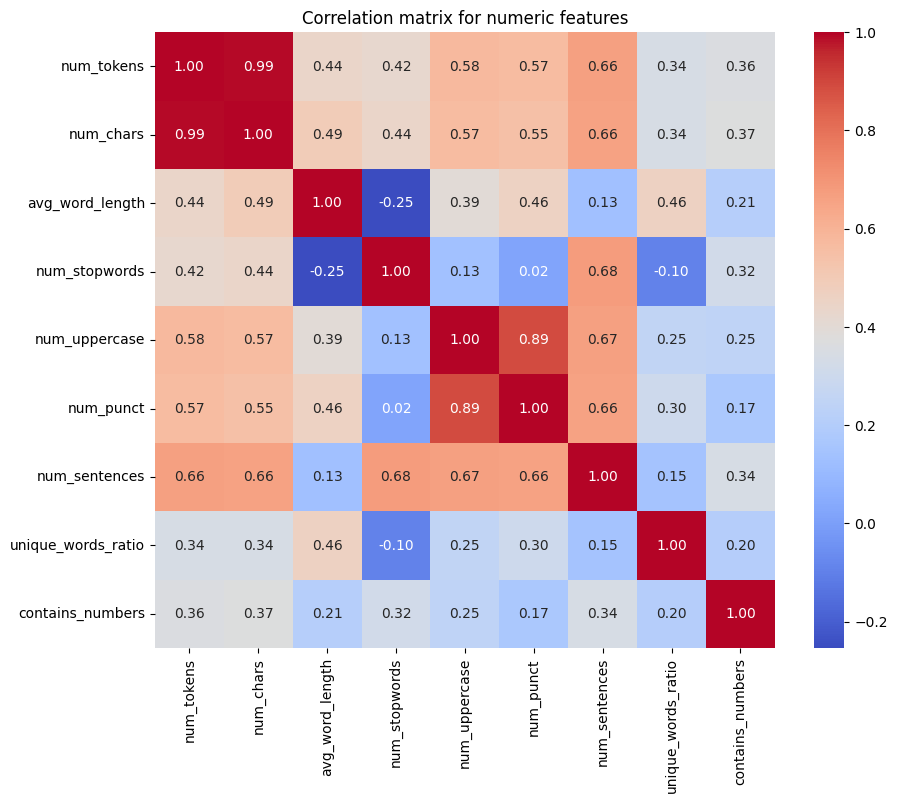


Paires de colonnes fortement corrélées (>|0.8|) :
       Feature 1  Feature 2  Correlation
0     num_tokens  num_chars     0.993985
1  num_uppercase  num_punct     0.889471


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
numeric_cols = [
    'num_tokens', 'num_chars', 'avg_word_length', 'num_stopwords',
    'num_uppercase', 'num_punct', 'num_sentences', 'unique_words_ratio',
    'contains_numbers'
]
corr_matrix = df_dataset[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix for numeric features")
plt.show()
strong_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        coef = corr_matrix.iloc[i, j]
        if abs(coef) > 0.8:
            strong_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], coef))

strong_corr_df = pd.DataFrame(strong_corr, columns=['Feature 1', 'Feature 2', 'Correlation'])
strong_corr_df = strong_corr_df.sort_values(by='Correlation', ascending=False)

print("\nPaires de colonnes fortement corrélées (>|0.8|) :")
print(strong_corr_df)

# Feature Importance Analysis for Highly Correlated Features with Respect to the Target

### Justification for Dropping Highly Correlated Columns

| Feature        | Correlated With   | Correlation | Importance | Decision        | Justification |
|----------------|-----------------|------------|------------|----------------|---------------|
| num_chars      | num_tokens       | 0.99       | 0.278      | Dropped         | Strongly correlated with `num_tokens` and has relatively low importance for the target. |
| num_uppercase  | num_punct        | 0.89       | 0.171      | Dropped         | Strongly correlated with `num_punct` and has relatively low importance for the target. |
| num_tokens     | -                | -          | 0.283      | Kept            | More important for prediction and less redundant. |
| num_punct      | -                | -          | 0.269      | Kept            | More important for prediction and less redundant. |


In [38]:
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import numpy as np

high_corr_cols = ['num_tokens', 'num_chars', 'num_uppercase', 'num_punct']
X = df_dataset[high_corr_cols]
y = df_dataset['cible']
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
model.fit(X, y)
importances = model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': high_corr_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nImportances des features fortement corrélées par rapport à la cible :")
print(feat_importance_df)


Importances des features fortement corrélées par rapport à la cible :
         Feature  Importance
0     num_tokens    0.282703
1      num_chars    0.278086
3      num_punct    0.268681
2  num_uppercase    0.170530


In [39]:
cols_to_drop = ['num_chars', 'num_punct']
df_dataset = df_dataset.drop(columns=cols_to_drop)
print("Colonnes restantes :", df_dataset.columns)

Colonnes restantes : Index(['cible', 'glove_0', 'glove_1', 'glove_2', 'glove_3', 'glove_4',
       'glove_5', 'glove_6', 'glove_7', 'glove_8',
       ...
       'zh', 'zi', 'zipping', 'ziygon', 'znale', 'zo', 'zondag', 'zone',
       'zoom', 'zu'],
      dtype='object', length=5328)


# Correlation Analysis of Numeric Features in Test Data

Compute the correlation matrix for numeric features in the test dataset and visualize it with a heatmap.  
Identify and list pairs of features with **strong correlation** (absolute value > 0.8) for potential feature selection or dimensionality reduction.


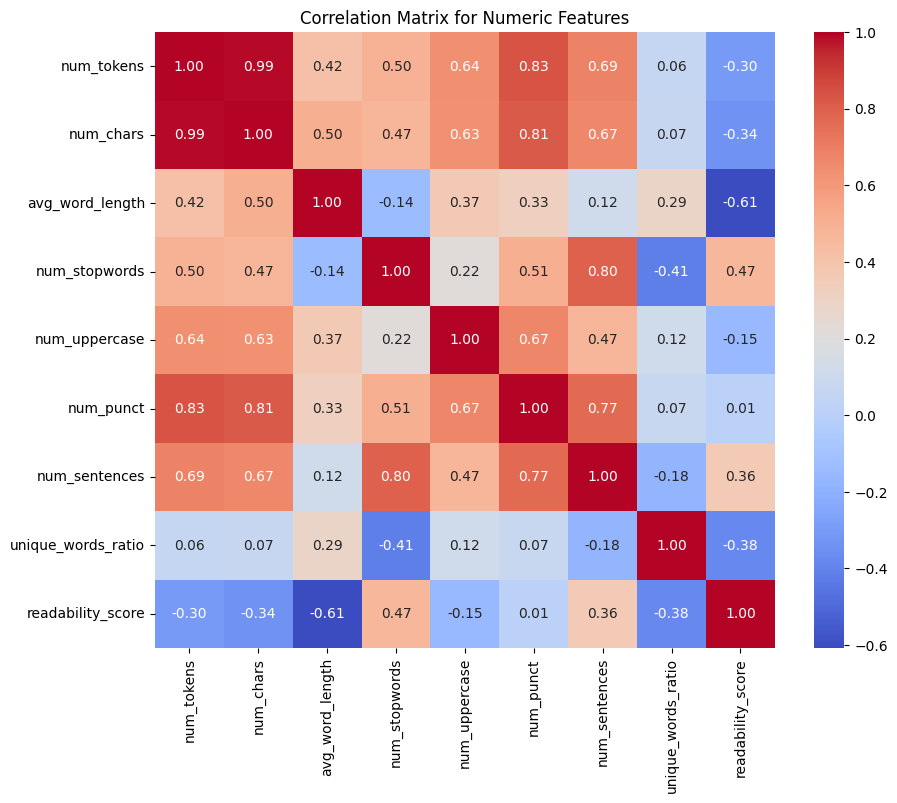

Pairs of strongly correlated features (>|0.8|):
    Feature 1  Feature 2  Correlation
0  num_tokens  num_chars     0.992736
1  num_tokens  num_punct     0.831494
2   num_chars  num_punct     0.813295


In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
numeric_cols = [
    'num_tokens', 'num_chars', 'avg_word_length', 'num_stopwords',
    'num_uppercase', 'num_punct', 'num_sentences', 'unique_words_ratio',
    'readability_score'
]
numeric_cols = [col for col in numeric_cols if col in df_test.columns]
corr_matrix = df_test[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()
strong_corr = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        col1 = numeric_cols[i]
        col2 = numeric_cols[j]
        corr_value = corr_matrix.loc[col1, col2]
        if abs(corr_value) > 0.8:
            strong_corr.append([col1, col2, corr_value])
strong_corr_df = pd.DataFrame(strong_corr, columns=['Feature 1', 'Feature 2', 'Correlation'])
strong_corr_df = strong_corr_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

print("Pairs of strongly correlated features (>|0.8|):")
print(strong_corr_df)

In [41]:
cols_to_drop = ['num_chars', 'num_punct']
df_test = df_test.drop(columns=cols_to_drop)
print("Colonnes restantes :", df_test.columns)

Colonnes restantes : Index(['glove_0', 'glove_1', 'glove_2', 'glove_3', 'glove_4', 'glove_5',
       'glove_6', 'glove_7', 'glove_8', 'glove_9',
       ...
       'zh', 'zi', 'zipping', 'ziygon', 'znale', 'zo', 'zondag', 'zone',
       'zoom', 'zu'],
      dtype='object', length=5326)


In [42]:
array_columns = []

for col in df_dataset.columns:
    if df_dataset[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any():
        array_columns.append(col)

if array_columns:
    print("⚠️ Columns still containing arrays or lists:", array_columns)
else:
    print("✅ No columns contain arrays or lists.")


⚠️ Columns still containing arrays or lists: ['ner_vector']


In [43]:
print(df_dataset.head())

   cible   glove_0   glove_1   glove_2   glove_3   glove_4   glove_5  \
0      1 -0.162039  0.117231  0.078288 -0.102709 -0.090067  0.074751   
1      0 -0.142063  0.108321  0.038451 -0.170812 -0.044408  0.041786   
2      1 -0.150080  0.254354  0.150232 -0.095800 -0.049088  0.064095   
3      0 -0.108867  0.104363  0.038277 -0.113675 -0.009672  0.005476   
4      1 -0.154070  0.110619  0.062109 -0.239737 -0.020680  0.033282   

    glove_6   glove_7   glove_8  ...   zh   zi  zipping  ziygon  znale   zo  \
0 -0.051247 -0.064483 -0.001818  ...  0.0  0.0      0.0     0.0    0.0  0.0   
1 -0.027919  0.015916  0.053771  ...  0.0  0.0      0.0     0.0    0.0  0.0   
2  0.016021  0.088732 -0.025034  ...  0.0  0.0      0.0     0.0    0.0  0.0   
3  0.006771  0.051564  0.003961  ...  0.0  0.0      0.0     0.0    0.0  0.0   
4 -0.097469 -0.067467  0.078761  ...  0.0  0.0      0.0     0.0    0.0  0.0   

   zondag  zone  zoom   zu  
0     0.0   0.0   0.0  0.0  
1     0.0   0.0   0.0  0.0  
2    

# train and build model

# Random Forest - Without Hyperparameter Optimization


In [44]:
import numpy as np
columns_to_check = df_dataset.columns  
for col in columns_to_check:
    if df_dataset[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any():
        print(f"⚠️ La colonne '{col}' contient des listes ou arrays !")


⚠️ La colonne 'ner_vector' contient des listes ou arrays !


In [45]:
df_dataset = df_dataset.drop(columns=['ner_vector']) 

# Detecting Columns Containing Lists or Arrays

In [46]:
def detect_array_columns(df):
    array_cols = []
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (list, tuple, pd.Series, np.ndarray))).any():
            array_cols.append(col)
    return array_cols

array_columns_dataset = detect_array_columns(df_dataset)
if array_columns_dataset:
    print("⚠️ Columns containing lists/arrays in df_dataset:", array_columns_dataset)
else:
    print("✅ No array-type columns detected in df_dataset.")

array_columns_test = detect_array_columns(df_test)
if array_columns_test:
    print("⚠️ Columns containing lists/arrays in df_test:", array_columns_test)
else:
    print("✅ No array-type columns detected in df_test.")

✅ No array-type columns detected in df_dataset.
✅ No array-type columns detected in df_test.


In [47]:
print(df_dataset.head())
print(df_dataset.shape)

   cible   glove_0   glove_1   glove_2   glove_3   glove_4   glove_5  \
0      1 -0.162039  0.117231  0.078288 -0.102709 -0.090067  0.074751   
1      0 -0.142063  0.108321  0.038451 -0.170812 -0.044408  0.041786   
2      1 -0.150080  0.254354  0.150232 -0.095800 -0.049088  0.064095   
3      0 -0.108867  0.104363  0.038277 -0.113675 -0.009672  0.005476   
4      1 -0.154070  0.110619  0.062109 -0.239737 -0.020680  0.033282   

    glove_6   glove_7   glove_8  ...   zh   zi  zipping  ziygon  znale   zo  \
0 -0.051247 -0.064483 -0.001818  ...  0.0  0.0      0.0     0.0    0.0  0.0   
1 -0.027919  0.015916  0.053771  ...  0.0  0.0      0.0     0.0    0.0  0.0   
2  0.016021  0.088732 -0.025034  ...  0.0  0.0      0.0     0.0    0.0  0.0   
3  0.006771  0.051564  0.003961  ...  0.0  0.0      0.0     0.0    0.0  0.0   
4 -0.097469 -0.067467  0.078761  ...  0.0  0.0      0.0     0.0    0.0  0.0   

   zondag  zone  zoom   zu  
0     0.0   0.0   0.0  0.0  
1     0.0   0.0   0.0  0.0  
2    

In [48]:
print(df_test.shape)

(2136, 5326)


# Random Forest Training and Evaluation

Train a Random Forest classifier on the dataset, evaluate it with cross-validation, and analyze overfitting.  
- Print detailed classification reports and confusion matrices for both **train** and **validation** sets.  
- Compare train and validation accuracy to detect potential overfitting.


In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_dataset.drop(columns=['cible'])
y = df_dataset['cible']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='log2',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"📊 Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"\n✅ Train Accuracy: {train_acc:.4f}")

print("\n" + "="*50)
print("📊 DETAILED REPORT - TRAIN")
print("="*50)
print("\n--- Classification Report (Train) ---")
print(classification_report(y_train, y_train_pred))
print("\n--- Confusion Matrix (Train) ---")
print(confusion_matrix(y_train, y_train_pred))

val_acc = accuracy_score(y_val, y_val_pred)
print(f"\n✅ Validation Accuracy: {val_acc:.4f}")

print("\n" + "="*50)
print("📊 DETAILED REPORT - VALIDATION")
print("="*50)
print("\n--- Classification Report (Validation) ---")
print(classification_report(y_val, y_val_pred))
print("\n--- Confusion Matrix (Validation) ---")
print(confusion_matrix(y_val, y_val_pred))
print("\n" + "="*50)
print("📈 OVERFITTING ANALYSIS")
print("="*50)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train-Val Gap: {abs(train_acc - val_acc):.4f}")

if abs(train_acc - val_acc) < 0.05:
    print("🎯 Well-regularized model - low overfitting")
else:
    print("⚠️ Overfitting detected - consider more regularization")

📊 Cross-validation Accuracy: 0.7510 ± 0.0956

✅ Train Accuracy: 0.9211

📊 DETAILED REPORT - TRAIN

--- Classification Report (Train) ---
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        76
           1       0.86      1.00      0.93        76

    accuracy                           0.92       152
   macro avg       0.93      0.92      0.92       152
weighted avg       0.93      0.92      0.92       152


--- Confusion Matrix (Train) ---
[[64 12]
 [ 0 76]]

✅ Validation Accuracy: 0.9211

📊 DETAILED REPORT - VALIDATION

--- Classification Report (Validation) ---
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        19
           1       0.86      1.00      0.93        19

    accuracy                           0.92        38
   macro avg       0.93      0.92      0.92        38
weighted avg       0.93      0.92      0.92        38


--- Confusion Matrix (Validation) ---
[[16  3]
 


# Random Forest Hyperparameter Tuning with RandomizedSearchCV

Perform hyperparameter tuning for a Random Forest classifier using **RandomizedSearchCV** with 5-fold stratified cross-validation.  
- Find the **best combination of hyperparameters** for accuracy.  
- Evaluate the tuned model on both **train** and **validation** sets, reporting accuracy and the train-validation gap to check for overfitting.


In [51]:

param_dist = {
    'n_estimators': [150, 200, 250],          
    'max_depth': [6, 8, 10],                 
    'min_samples_split': [5, 10, 15],         
    'min_samples_leaf': [2, 4, 6],           
    'max_features': ['sqrt', 'log2'],         
    'bootstrap': [True]                        
}
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,                  
    scoring='accuracy',
    cv=cv,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("🏆 Best hyperparameters:", random_search.best_params_)
print(f"Best CV score: {random_search.best_score_:.4f}")
best_rf = random_search.best_estimator_

y_train_pred = best_rf.predict(X_train)
y_val_pred = best_rf.predict(X_val)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Gap Train-Val: {abs(train_acc - val_acc):.4f}")

🏆 Best hyperparameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 6, 'bootstrap': True}
Best CV score: 0.7510
Train Accuracy: 0.9211
Validation Accuracy: 0.9211
Gap Train-Val: 0.0000


# Random Forest Training and Evaluation (Tuned Parameters)

Train a Random Forest classifier with custom hyperparameters, evaluate it using cross-validation,  
and report detailed metrics for both **train** and **validation** sets.  
Analyze the train-validation gap to detect potential overfitting.


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_dataset.drop(columns=['cible'])
y = df_dataset['cible']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=7,
    min_samples_split=14,
    min_samples_leaf=6,
    max_features='log2',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"📊 Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"\n✅ Train Accuracy: {train_acc:.4f}")

print("\n" + "="*50)
print("📊 DETAILED REPORT - TRAIN")
print("="*50)
print("\n--- Classification Report (Train) ---")
print(classification_report(y_train, y_train_pred))
print("\n--- Confusion Matrix (Train) ---")
print(confusion_matrix(y_train, y_train_pred))

val_acc = accuracy_score(y_val, y_val_pred)
print(f"\n✅ Validation Accuracy: {val_acc:.4f}")

print("\n" + "="*50)
print("📊 DETAILED REPORT - VALIDATION")
print("="*50)
print("\n--- Classification Report (Validation) ---")
print(classification_report(y_val, y_val_pred))
print("\n--- Confusion Matrix (Validation) ---")
print(confusion_matrix(y_val, y_val_pred))

print("\n" + "="*50)
print("📈 OVERFITTING ANALYSIS")
print("="*50)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train-Val Gap: {abs(train_acc - val_acc):.4f}")

if abs(train_acc - val_acc) < 0.05:
    print("🎯 Well-regularized model - low overfitting")
else:
    print("⚠️ Overfitting detected - consider more regularization")

📊 Cross-validation Accuracy: 0.7112 ± 0.0728

✅ Train Accuracy: 0.8618

📊 DETAILED REPORT - TRAIN

--- Classification Report (Train) ---
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        76
           1       0.78      1.00      0.88        76

    accuracy                           0.86       152
   macro avg       0.89      0.86      0.86       152
weighted avg       0.89      0.86      0.86       152


--- Confusion Matrix (Train) ---
[[55 21]
 [ 0 76]]

✅ Validation Accuracy: 0.8947

📊 DETAILED REPORT - VALIDATION

--- Classification Report (Validation) ---
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        19
           1       0.83      1.00      0.90        19

    accuracy                           0.89        38
   macro avg       0.91      0.89      0.89        38
weighted avg       0.91      0.89      0.89        38


--- Confusion Matrix (Validation) ---
[[15  4]
 

# Ensemble RandomForest – Soft Voting for Robust Predictions

# Soft Voting in Ensemble Classifiers (Two Classes)

Soft voting combines the **predicted probabilities** of multiple classifiers and selects the class with the highest **average probability**.  

| Sample | RF Model 1 Probabilities | RF Model 2 Probabilities | Average Probabilities | Predicted Class |
|--------|------------------------|------------------------|---------------------|----------------|
| Article 1 | [0.3, 0.7]            | [0.4, 0.6]            | [0.35, 0.65]       | Class 1        |
| Article 2 | [0.8, 0.2]            | [0.7, 0.3]            | [0.75, 0.25]       | Class 0        |
| Article 3 | [0.5, 0.5]            | [0.6, 0.4]            | [0.55, 0.45]       | Class 0        |

- Each classifier outputs a probability for **Class 0** and **Class 1**.  
- The ensemble **averages the probabilities** for each class.  
- The class with the **highest average probability** becomes the final predicted class.


In [53]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model_1 = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    min_samples_split=15,
    min_samples_leaf=6,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_model_2 = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    min_samples_split=15,
    min_samples_leaf=6,
    max_features='sqrt',
    bootstrap=True,
    random_state=43,  
    n_jobs=-1
)

ensemble_model = VotingClassifier(
    estimators=[
        ('rf1', rf_model_1),
        ('rf2', rf_model_2)
    ],
    voting='soft',
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"📊 Ensemble RF CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

ensemble_model.fit(X_train, y_train)
y_train_pred = ensemble_model.predict(X_train)
y_val_pred = ensemble_model.predict(X_val)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"\n✅ Train Accuracy: {train_acc:.4f}")

print("\n--- Classification Report (Train) ---")
print(classification_report(y_train, y_train_pred))
print("\n--- Confusion Matrix (Train) ---")
print(confusion_matrix(y_train, y_train_pred))

val_acc = accuracy_score(y_val, y_val_pred)
print(f"\n✅ Validation Accuracy: {val_acc:.4f}")

print("\n--- Classification Report (Validation) ---")
print(classification_report(y_val, y_val_pred))
print("\n--- Confusion Matrix (Validation) ---")
print(confusion_matrix(y_val, y_val_pred))

gap = abs(train_acc - val_acc)
print("\n📈 OVERFITTING ANALYSIS:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train-Val Gap: {gap:.4f}")

if gap < 0.05:
    print("✅ Well-regularized model - low overfitting")
else:
    print("⚠️ Overfitting detected - consider more regularization")

📊 Ensemble RF CV Accuracy: 0.7114 ± 0.0878

✅ Train Accuracy: 0.9474

--- Classification Report (Train) ---
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        76
           1       0.90      1.00      0.95        76

    accuracy                           0.95       152
   macro avg       0.95      0.95      0.95       152
weighted avg       0.95      0.95      0.95       152


--- Confusion Matrix (Train) ---
[[68  8]
 [ 0 76]]

✅ Validation Accuracy: 0.8947

--- Classification Report (Validation) ---
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.86      0.95      0.90        19

    accuracy                           0.89        38
   macro avg       0.90      0.89      0.89        38
weighted avg       0.90      0.89      0.89        38


--- Confusion Matrix (Validation) ---
[[16  3]
 [ 1 18]]

📈 OVERFITTING ANALYSIS:
Train Accuracy: 0.9474
Vali

# Training XGBoost for Binary Article Classification

We train an **XGBoost model** (`XGBClassifier`) to classify articles into two classes (0 or 1).

## Process

1. **Data**: Features `X_train`, labels `y_train`; validation set `X_val`, `y_val`.
2. **Model**: XGBoost classifier with pre-set robust hyperparameters (n_estimators, max_depth, learning_rate, regularization).
3. **Training**: Fit the model on the training data.
4. **Prediction**: 
   - On training set: `y_train_pred = xgb_model.predict(X_train)`
   - On validation set: `y_val_pred = xgb_model.predict(X_val)`
5. **Evaluation**:
   - Compute accuracy on train and validation.
   - Classification report and confusion matrix.
   - Gap between train and validation accuracy to check overfitting.
6. **Optimization**: Hyperparameters are manually chosen for robustness; no automated hyperparameter tuning is done here.


In [54]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
robust_params = {
    'n_estimators': 130,
    'max_depth': 2,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 1.0,
    'gamma': 0.1,
    'reg_alpha': 3,
    'reg_lambda': 6,
    'objective': 'binary:logistic',
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42,
    'n_jobs': -1
}
xgb_model = xgb.XGBClassifier(**robust_params)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"📊 Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\n✅ Train Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"Gap Train-Val: {abs(train_acc - val_acc):.4f}")

print("\n--- Classification Report (Train) ---")
print(classification_report(y_train, y_train_pred))
print("\n--- Classification Report (Validation) ---")
print(classification_report(y_val, y_val_pred))

print("\n--- Confusion Matrix (Train) ---")
print(confusion_matrix(y_train, y_train_pred))
print("\n--- Confusion Matrix (Validation) ---")
print(confusion_matrix(y_val, y_val_pred))


📊 Cross-validation Accuracy: 0.7310 ± 0.0732

✅ Train Accuracy: 0.9539
✅ Validation Accuracy: 0.8421
Gap Train-Val: 0.1118

--- Classification Report (Train) ---
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        76
           1       0.92      1.00      0.96        76

    accuracy                           0.95       152
   macro avg       0.96      0.95      0.95       152
weighted avg       0.96      0.95      0.95       152


--- Classification Report (Validation) ---
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        19
           1       0.84      0.84      0.84        19

    accuracy                           0.84        38
   macro avg       0.84      0.84      0.84        38
weighted avg       0.84      0.84      0.84        38


--- Confusion Matrix (Train) ---
[[69  7]
 [ 0 76]]

--- Confusion Matrix (Validation) ---
[[16  3]
 [ 3 16]]


# SVM for Binary Article Classification – Summary

- **Model**: Support Vector Machine (`SVC`)  
- **Task**: Predict class `0` or `1` for articles.  
- **Hyperparameters**: Optimized using `RandomizedSearchCV` with 5-fold stratified CV.  
- **Training**: Fit best SVM on `X_train`, `y_train`.  
- **Prediction**: For each article, the class with the higher probability is chosen.  
- **Evaluation**: Accuracy, classification report, confusion matrix, and train-validation gap to detect overfitting.


In [56]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
param_dist = {
    'C': [0.1, 1, 10, 50],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'degree': [2, 3, 4], 
    'coef0': [0.0, 0.1, 0.5]  
}
svm_base = SVC(probability=True, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=svm_base,
    param_distributions=param_dist,
    n_iter=30,                  
    scoring='accuracy',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

print("🏆 Best hyperparameters:", random_search.best_params_)
print(f"Best CV score: {random_search.best_score_:.4f}")
best_svm = random_search.best_estimator_
cv_scores = cross_val_score(best_svm, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"📊 Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
best_svm.fit(X_train, y_train)
y_train_pred = best_svm.predict(X_train)
y_val_pred = best_svm.predict(X_val)
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\n✅ Train Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"Gap Train-Val: {abs(train_acc - val_acc):.4f}")

print("\n--- Classification Report (Train) ---")
print(classification_report(y_train, y_train_pred))
print("\n--- Classification Report (Validation) ---")
print(classification_report(y_val, y_val_pred))

print("\n--- Confusion Matrix (Train) ---")
print(confusion_matrix(y_train, y_train_pred))
print("\n--- Confusion Matrix (Validation) ---")
print(confusion_matrix(y_val, y_val_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
🏆 Best hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'coef0': 0.5, 'C': 1}
Best CV score: 0.6714
📊 Cross-validation Accuracy: 0.6714 ± 0.0771

✅ Train Accuracy: 0.7171
✅ Validation Accuracy: 0.7895
Gap Train-Val: 0.0724

--- Classification Report (Train) ---
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        76
           1       0.72      0.71      0.72        76

    accuracy                           0.72       152
   macro avg       0.72      0.72      0.72       152
weighted avg       0.72      0.72      0.72       152


--- Classification Report (Validation) ---
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           1       0.92      0.63      0.75        19

    accuracy                           0.79        38
   macro avg       0.82      0.79      0.78        38
weighted avg     

# Hard Voting Ensemble for Binary Article Classification – Summary

- **Models in Ensemble**:
  1. Random Forest (`rf_model_1`)
  2. Random Forest (`rf_model_2`)
  3. XGBoost (`xgb_model`)

- **Task**: Predict class `0` or `1` for articles using a **hard voting ensemble**.  

- **Voting Mechanism**:  
  Each base model predicts a class; the final predicted class is the **majority vote** among the models.

- **Training**: Fit the ensemble on `X_train`, `y_train`.

- **Prediction**:
  - `y_train_pred` → predictions on training set  
  - `y_val_pred` → predictions on validation set  

- **Evaluation**:
  - 5-fold cross-validation accuracy on training set
  - Train and validation accuracy
  - Classification reports and confusion matrices
  - Train-validation accuracy gap to assess overfitting

- **Hyperparameter Optimization**: Manual; each model uses pre-defined robust parameters.


In [57]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rf_model_1 = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    min_samples_split=15,
    min_samples_leaf=6,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf_model_2 = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,
    min_samples_split=15,
    min_samples_leaf=6,
    max_features='sqrt',
    bootstrap=True,
    random_state=43,
    n_jobs=-1
)
xgb_model = XGBClassifier(
    n_estimators=130,
    max_depth=2,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=1.0,
    gamma=0.1,
    reg_alpha=3,
    reg_lambda=6,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
hard_ensemble = VotingClassifier(
    estimators=[
        ('rf1', rf_model_1),
        ('rf2', rf_model_2),
        ('xgb', xgb_model)
    ],
    voting='hard',
    n_jobs=-1
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(hard_ensemble, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"📊 Hard Voting Ensemble CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
hard_ensemble.fit(X_train, y_train)
y_train_pred = hard_ensemble.predict(X_train)
y_val_pred = hard_ensemble.predict(X_val)
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\n✅ Train Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"📈 Gap Train-Val: {abs(train_acc - val_acc):.4f}")

print("\n--- Classification Report (Train) ---")
print(classification_report(y_train, y_train_pred))
print("\n--- Classification Report (Validation) ---")
print(classification_report(y_val, y_val_pred))

print("\n--- Confusion Matrix (Train) ---")
print(confusion_matrix(y_train, y_train_pred))
print("\n--- Confusion Matrix (Validation) ---")
print(confusion_matrix(y_val, y_val_pred))

📊 Hard Voting Ensemble CV Accuracy: 0.7439 ± 0.0537

✅ Train Accuracy: 0.9605
✅ Validation Accuracy: 0.8947
📈 Gap Train-Val: 0.0658

--- Classification Report (Train) ---
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        76
           1       0.93      1.00      0.96        76

    accuracy                           0.96       152
   macro avg       0.96      0.96      0.96       152
weighted avg       0.96      0.96      0.96       152


--- Classification Report (Validation) ---
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.86      0.95      0.90        19

    accuracy                           0.89        38
   macro avg       0.90      0.89      0.89        38
weighted avg       0.90      0.89      0.89        38


--- Confusion Matrix (Train) ---
[[70  6]
 [ 0 76]]

--- Confusion Matrix (Validation) ---
[[16  3]
 [ 1 18]]


# Comparative Performance of Models for Binary Article Classification

| Model | CV Accuracy (mean ± std) | Train Accuracy | Validation Accuracy | Gap Train-Val | Overfitting | Notes |
|-------|-------------------------|----------------|-------------------|---------------|-------------|-------|
| Random Forest 1 | 0.7510 ± 0.0956 | 0.9211 | 0.9211 | 0.0000 | Low | Well-regularized, perfect balance. ✅ Public competition score: 0.85 |
| Random Forest 2 | 0.7112 ± 0.0728 | 0.8618 | 0.8947 | 0.0329 | Low | Regularized, slightly less performant than RF1 |
| Ensemble RF (Soft Voting) | 0.7114 ± 0.0878 | 0.9474 | 0.8947 | 0.0526 | Medium | Slight overfitting detected |
| XGBoost | 0.7310 ± 0.0732 | 0.9539 | 0.8421 | 0.1118 | High | High overfitting, lower validation performance |
| SVM | 0.6714 ± 0.0771 | 0.7171 | 0.7895 | 0.0724 | Medium | Overall less performant |
| Hard Voting Ensemble | 0.7439 ± 0.0537 | 0.9605 | 0.8947 | 0.0658 | Medium | Good trade-off between power and regularization |

## Interpretation

- **Random Forest 1**: Best balance between performance and regularization; negligible train-validation gap.  
  ✅ It achieved a **public competition score of 0.85**, confirming its robustness on unseen data.
- **Ensembles (Soft/Hard Voting)**: Slightly higher power but small overfitting observed.
- **XGBoost**: High train accuracy but suffers from overfitting; lower validation accuracy.
- **SVM**: Overall lower performance on this dataset.

## Conclusion

For this dataset, the most reliable and well-regularized model is **Random Forest 1**, which also performed well on the competition with a public score of 0.85.  
If a more powerful model is desired with some tolerance for overfitting, **Hard Voting Ensemble** is a valid option.